In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from pprint import pprint
from skimage.io import imread
from torch.utils.data import DataLoader
import utils
from models import HumerusDataset, Rescale, NoneTransform
import torch
from torch import nn
import torchvision
print(f'Pytorch version: {torch.__version__}, Torchvision version: {torchvision.__version__}')
from PIL import Image

Pytorch version: 2.0.0+cpu, Torchvision version: 0.15.1+cpu


In [2]:
path=glob.glob(os.path.join('MURA-v1.1','*','*','*', '*','*.png'))
pprint(path)


['MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00011\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00016\\study1_positive\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00026\\study1_negative\\image3.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00031\\study1_negative\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image1.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient00034\\study1_positive\\image2.png',
 'MURA-v1.1\\train\\XR_ELBOW\\patient0

We try to concatenate all the info about the images in one dataset
We use the character '\\' because one '\' is the escape and the other separates the subfolders in our OS (Windows). if we worked in linux we would use the character '/'
THere are two studies :study 1 and study 2

In [3]:
everythingScans_df=pd.DataFrame(dict(path=path))
everythingScans_df['Split']=everythingScans_df['path'].map(lambda x:x.split('\\')[1])
everythingScans_df['Bone']=everythingScans_df['path'].map(lambda x:x.split('\\')[2])
everythingScans_df['Patient']=everythingScans_df['path'].map(lambda x:x.split('\\')[3])
everythingScans_df['FolderName']=everythingScans_df['path'].map(lambda x:x.split('\\')[4])
everythingScans_df['Study']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[0])
everythingScans_df['Label']=everythingScans_df['path'].map(lambda x:x.split('\\')[4].split('_')[1])
everythingScans_df.sample(10)

path  Split         Bone  \
1775   MURA-v1.1\train\XR_ELBOW\patient05240\study1_p...  train     XR_ELBOW   
16805  MURA-v1.1\train\XR_HAND\patient10965\study1_ne...  train      XR_HAND   
30896  MURA-v1.1\train\XR_WRIST\patient07017\study1_p...  train     XR_WRIST   
21490  MURA-v1.1\train\XR_SHOULDER\patient00896\study...  train  XR_SHOULDER   
35105  MURA-v1.1\train\XR_WRIST\patient08521\study1_n...  train     XR_WRIST   
19247  MURA-v1.1\train\XR_SHOULDER\patient00178\study...  train  XR_SHOULDER   
28280  MURA-v1.1\train\XR_WRIST\patient04290\study1_n...  train     XR_WRIST   
32099  MURA-v1.1\train\XR_WRIST\patient07390\study1_p...  train     XR_WRIST   
36716  MURA-v1.1\train\XR_WRIST\patient09051\study1_n...  train     XR_WRIST   
17401  MURA-v1.1\train\XR_HAND\patient11183\study1_ne...  train      XR_HAND   

            Patient       FolderName   Study     Label  
1775   patient05240  study1_positive  study1  positive  
16805  patient10965  study1_negative  study1  negative  
30896  patient07017  study1_positive  study1  positive  
21490  patient00896  study1_positive  study1  positive  
35105  patient08521  study1_negative  study1  negative  
19247  patient00178  study1_positive  study1  positive  
28280  patient04290  study1_negative  study1  negative  
32099  patient07390  study1_positive  study1  positive  
36716  patient09051  study1_negative  study1  negative  
17401  patient11183  study1_negative  study1  negative

We check if some data is missing

In [4]:
print(everythingScans_df.isnull().values.any())
a=[0 if (x=='positive' or x=='negative') else 1 for x in everythingScans_df['Label'] ]
print(sum(a))

False
0


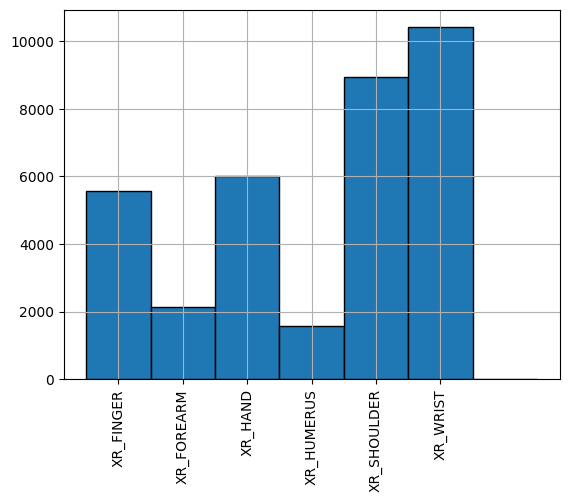

In [5]:

everythingScans_df['Bone'].hist(bins=range(1,9),rwidth=1, align='left',edgecolor='black')
plt.xticks(rotation=90)
plt.show()

# Explore some examples of images
When groupping by two values we need to define how the values will be combined.
get combinations of pics with same label and bone then choose one randomly 

In [6]:
onePairPic_df=everythingScans_df.groupby(['Label','Bone']).apply(lambda x:x.sample(1))
onePairPic_df.reset_index(drop=True)

path  Split         Bone  \
0   MURA-v1.1\train\XR_ELBOW\patient05897\study1_n...  train     XR_ELBOW   
1   MURA-v1.1\train\XR_FINGER\patient03829\study1_...  train    XR_FINGER   
2   MURA-v1.1\train\XR_FOREARM\patient09655\study1...  train   XR_FOREARM   
3   MURA-v1.1\train\XR_HAND\patient10889\study1_ne...  train      XR_HAND   
4   MURA-v1.1\train\XR_HUMERUS\patient00687\study1...  train   XR_HUMERUS   
5   MURA-v1.1\train\XR_SHOULDER\patient01507\study...  train  XR_SHOULDER   
6   MURA-v1.1\train\XR_WRIST\patient08195\study1_n...  train     XR_WRIST   
7   MURA-v1.1\train\XR_ELBOW\patient05242\study1_p...  train     XR_ELBOW   
8   MURA-v1.1\train\XR_FINGER\patient03395\study1_...  train    XR_FINGER   
9   MURA-v1.1\train\XR_FOREARM\patient03303\study1...  train   XR_FOREARM   
10  MURA-v1.1\train\XR_HAND\patient10091\study1_po...  train      XR_HAND   
11  MURA-v1.1\train\XR_HUMERUS\patient02906\study1...  train   XR_HUMERUS   
12  MURA-v1.1\train\XR_SHOULDER\patient01038\study...  train  XR_SHOULDER   
13  MURA-v1.1\valid\XR_WRIST\patient11263\study1_p...  valid     XR_WRIST   

         Patient       FolderName   Study     Label  
0   patient05897  study1_negative  study1  negative  
1   patient03829  study1_negative  study1  negative  
2   patient09655  study1_negative  study1  negative  
3   patient10889  study1_negative  study1  negative  
4   patient00687  study1_negative  study1  negative  
5   patient01507  study1_negative  study1  negative  
6   patient08195  study1_negative  study1  negative  
7   patient05242  study1_positive  study1  positive  
8   patient03395  study1_positive  study1  positive  
9   patient03303  study1_positive  study1  positive  
10  patient10091  study1_positive  study1  positive  
11  patient02906  study1_positive  study1  positive  
12  patient01038  study1_positive  study1  positive  
13  patient11263  study1_positive  study1  positive

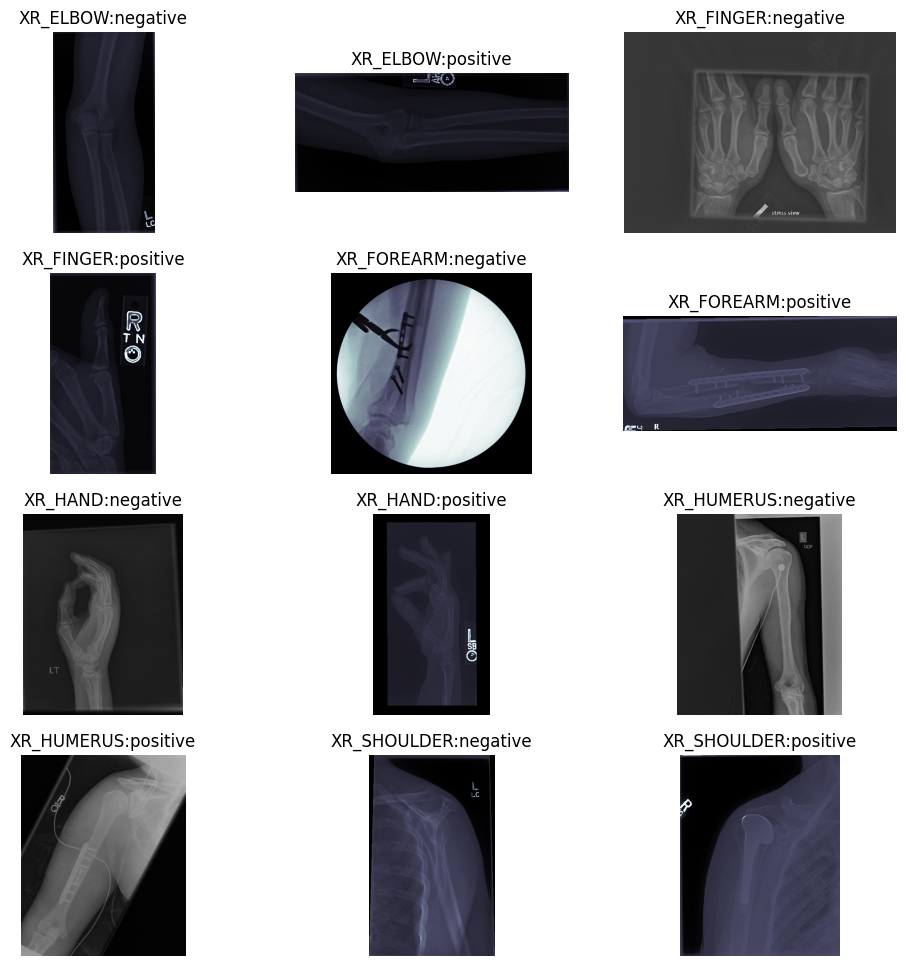

In [7]:
sub_df = everythingScans_df.groupby(['Bone', 'Label']).apply(lambda x: x.sample(1)).reset_index(drop = True)
fig, (m_axs) = plt.subplots(4, sub_df.shape[0]//4, figsize = (12, 12))
for c_ax, (_, c_row) in zip(m_axs.flatten(), sub_df.iterrows()):
    c_ax.imshow(imread(c_row['path']), cmap = 'bone')
    c_ax.axis('off')
    c_ax.set_title('{Bone}:{Label}'.format(**c_row))

In [8]:
# try working only on humerus

humerus_df=everythingScans_df.loc[everythingScans_df['Bone']=='XR_HUMERUS'].copy()
humerus_df.sample(10)

path  Split        Bone  \
17499  MURA-v1.1\train\XR_HUMERUS\patient02132\study1...  train  XR_HUMERUS   
17861  MURA-v1.1\train\XR_HUMERUS\patient02844\study1...  train  XR_HUMERUS   
17567  MURA-v1.1\train\XR_HUMERUS\patient02715\study1...  train  XR_HUMERUS   
18508  MURA-v1.1\train\XR_HUMERUS\patient03142\study1...  train  XR_HUMERUS   
17695  MURA-v1.1\train\XR_HUMERUS\patient02768\study1...  train  XR_HUMERUS   
17862  MURA-v1.1\train\XR_HUMERUS\patient02845\study1...  train  XR_HUMERUS   
18572  MURA-v1.1\train\XR_HUMERUS\patient03174\study1...  train  XR_HUMERUS   
17903  MURA-v1.1\train\XR_HUMERUS\patient02862\study1...  train  XR_HUMERUS   
38597  MURA-v1.1\valid\XR_HUMERUS\patient11619\study1...  valid  XR_HUMERUS   
18011  MURA-v1.1\train\XR_HUMERUS\patient02910\study1...  train  XR_HUMERUS   

            Patient       FolderName   Study     Label  
17499  patient02132  study1_negative  study1  negative  
17861  patient02844  study1_positive  study1  positive  
17567  patient02715  study1_positive  study1  positive  
18508  patient03142  study1_negative  study1  negative  
17695  patient02768  study1_positive  study1  positive  
17862  patient02845  study1_positive  study1  positive  
18572  patient03174  study1_negative  study1  negative  
17903  patient02862  study1_positive  study1  positive  
38597  patient11619  study1_positive  study1  positive  
18011  patient02910  study1_positive  study1  positive

c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([3, 256, 256]) 0
<class 'torch.Tensor'>


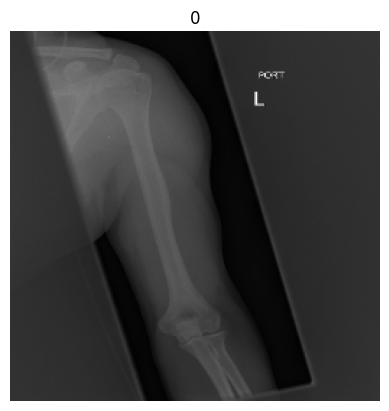

In [10]:
#DO NOT add transforms.ToTensor() to the transform list!
data_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256])
])

img, label = HumerusDataset(humerus_df,data_transforms).__getitem__(5)
#shape attributed evaluated at runtime depending on the dataset implementation

print(img.shape, label)
print(type(img))
utils.show_image_w_label(img, label)

In [13]:
BATCH_SIZE=32
transormation=torchvision.transforms.Compose([
    torchvision.transforms.Resize([256,256]),
])

train_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='train'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader=DataLoader(HumerusDataset(humerus_df.loc[humerus_df['Split']=='valid'].copy(),transform=transormation), batch_size=BATCH_SIZE, shuffle=True)


# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, valid_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(valid_dataloader)} batches of {BATCH_SIZE}")

# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x0000022B014E99F0>, <torch.utils.data.dataloader.DataLoader object at 0x0000022B7FD4CAC0>)
Length of train dataloader: 40 batches of 32
Length of test dataloader: 9 batches of 32


c:\Users\pchrk\OneDrive\Desktop\pms cs\NLP\NLP\nlp_venv\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


(torch.Size([32, 3, 256, 256]), torch.Size([32]))